# Practical 2: Optical Remote Sensing

In this practical, we'll visualize and analyze Landsat 8 imagery data from difference places. This includes creating composites and calculating indices to highlight different features in the data.

> ℹ️ **Credit:** The Mato Grosso data and topic used for this practical is based on the report done by Joseph Allen for the 2020 edition of ENVS258 Environment Geophysics - University of Liverpool.

---

## Cheatsheet

As a useful reference, here are the Landsat 8 bands:

| Band | Wavelength (µm) | Resolution (m) |
|------|:---------------:|:--------------:|
| 1-Ultra Blue  | 0.435-0.451  | 30 |
| 2-Blue  | 0.452-0.512  | 30 |
| 3-Green  | 0.533-0.590  | 30 |
| 4-Red  | 0.636-0.673  | 30 |
| 5-NIR  | 0.851-0.879  | 30 |
| 6-SWIR 1  | 1.566-1.651  | 30 |
| 7-SWIR 2  | 2.107-2.294  | 30 |
| 8-Panchromatic  | 0.503-0.676  | 15 |
| 9-Cirrus  | 1.363-1.384  | 30 |
| 10-Thermal 1  | 10.60-11.19  | 100 |
| 11-Thermal 2  | 11.50-12.51  | 100 |

---

## Import the required libraries

We'll start by importing the things we'll need to load the images, do some calculations, and plot them. 

> 💡 **Tip:** It's a good idea to put all your imports at the very first code cell of your notebook. This way you can easily check what needs to be installed for your notebook to work.

In [1]:
import skimage.io
import skimage.exposure
import numpy as np
import matplotlib.pyplot as plt
# This is new. We'll use it do insert a Google Maps into the notebook.
import IPython.display

---

## Data files

Throughout this notebook, we'll use two Landsat 8 scenes (cropped to make the files smaller):

* [mato_gross.zip](https://github.com/leouieda/remote-sensing/releases/download/2020%2F21/mato_grosso.zip)
* [thomas_fire.zip](https://github.com/leouieda/remote-sensing/releases/download/2020%2F21/thomas_fire.zip)

Download both zip archives and unzip them in **the same folder as this notebooks**.

The first part, we'll use `mato_grosso.zip` data that contains two scenes from the city of Cláudia in Mato Grosso, Brazil, from 2014 and 2020.

> 💡 **Tip:** Use the `IPython.display` module to insert things into your notebook. Basically anything that can be put on a web page is fair game. Here, I copied the `<iframe>` code that Google Maps provides when you go to "Share > Embed a map".

In [2]:
IPython.display.IFrame(width="100%", height=600, src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d525892.5387584838!2d-54.96848048271206!3d-11.571918929162646!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x93085c24b5761be7%3A0x84aeab22a06ee74b!2sCl%C3%A1udia%2C%20State%20of%20Mato%20Grosso%2C%2078540-000%2C%20Brazil!5e1!3m2!1sen!2suk!4v1643801073321!5m2!1sen!2suk")

Let's start with the 2014 scene. We'll once again use scikit-image to load the bands from the `.tif` files.

In [3]:
brazil_2014_blue = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20140804_20200911_02_T1_cropped/LC08_L2SP_226068_20140804_20200911_02_T1_B2.TIF")
brazil_2014_green = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20140804_20200911_02_T1_cropped/LC08_L2SP_226068_20140804_20200911_02_T1_B3.TIF")
brazil_2014_red = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20140804_20200911_02_T1_cropped/LC08_L2SP_226068_20140804_20200911_02_T1_B4.TIF")
brazil_2014_nir = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20140804_20200911_02_T1_cropped/LC08_L2SP_226068_20140804_20200911_02_T1_B5.TIF")

In [4]:
brazil_2014_blue

array([[7845, 7829, 7780, ..., 7868, 7729, 7752],
       [7811, 7771, 7781, ..., 7830, 7685, 7708],
       [7811, 7781, 7794, ..., 7719, 7705, 7728],
       ...,
       [7798, 7820, 7846, ..., 7718, 7743, 7740],
       [7815, 7814, 7890, ..., 7737, 7719, 7725],
       [7841, 7806, 7850, ..., 7710, 7767, 7731]], dtype=uint16)

Remember that what we load is a **digitized** version of the reflectance of light on each particular frequency band. For doing any **quantitative analysis**, we would need to first **convert this digitized data into reflectance**. We've done this before and it's a matter of finding out the **multiplicative and additive** constants for the particular bands that we're using. 

> 💡 **Tip:** To find those, open the `*_MTL.txt` files that come with each scene. They contain information about these parameters as well as the geographic coordinates, projection, date, processing level, citations, etc. Look for `GROUP = LEVEL2_SURFACE_REFLECTANCE_PARAMETERS` to find `REFLECTANCE_MULT_BAND_X` and `REFLECTANCE_ADD_BAND_X` to find the parameters that we need.

Since this is an operation that we have to do for each band, and the parameters values are the same for the bands we're using, let's make a **function** that does this so we don't repeat ourselves.

In [5]:
def convert_to_reflectance(band):
    """
    Convert a band from digitized to reflectance. 
    Works for bands 1-7 only.
    """
    mult_parameter = 2.75e-05
    add_parameter = -0.2
    return band * mult_parameter + add_parameter

Now apply it to our bands:

In [6]:
brazil_2014_blue_reflect = convert_to_reflectance(brazil_2014_blue)
brazil_2014_green_reflect = convert_to_reflectance(brazil_2014_green)
brazil_2014_red_reflect = convert_to_reflectance(brazil_2014_red)
brazil_2014_nir_reflect = convert_to_reflectance(brazil_2014_nir)

> 💡 **Tip:** This would be even better using a *dictionary* to store the bands (instead of individual variables) paired with a `for` loop.

Let's plot only the green band first to quickly inspect the data:

Text(0, 0.5, 'northing (pixels)')

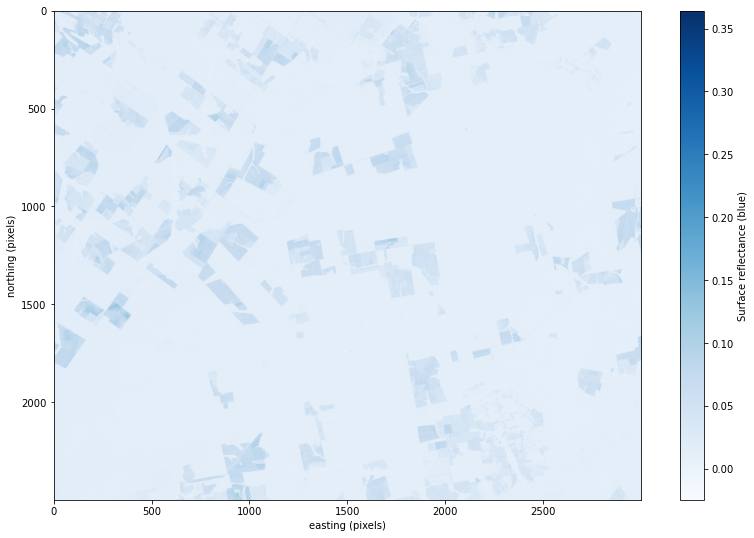

In [7]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_2014_blue_reflect, cmap="Blues")
plt.colorbar(label="Surface reflectance (blue)")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

Looks OK and not obviously bad data.

---

## Creating composites

We'll start by learning how to create **composites** from the different bands provided by the Landsat 8 satellite. Other satellites use different band combinations but the underlying principles are the same. Let's see if we can make and visualize an **RBG (true color) composite**.

Since we're going to plot this with matplotlib, we need to make it in a format that matplotlib accepts:

1. A 3D numpy array 
1. First 2 dimensions are the northing and easting (same as the individual bands)
1. Third dimension should have 3 elements: red, green, and blue intensity.
1. Data has to be 8-bit unsigned integers (`uint8`)

To make something like that, we'll start with an empty numpy array of the right **shape** and **type**. 

In [8]:
nrows, ncols = brazil_2014_blue.shape
brazil_rgb_2014 = np.empty((nrows, ncols, 3), dtype="uint8")

Then we can add each band to the respective element of the third dimension of the composite. The bands need to be rescaled to 8-bit integers (0-255 range) using our old friend `skimage.exposure.rescale_intensity`.

In [9]:
brazil_rgb_2014[:, :, 0] = skimage.exposure.rescale_intensity(brazil_2014_red_reflect, out_range="uint8")
brazil_rgb_2014[:, :, 1] = skimage.exposure.rescale_intensity(brazil_2014_green_reflect, out_range="uint8")
brazil_rgb_2014[:, :, 2] = skimage.exposure.rescale_intensity(brazil_2014_blue_reflect, out_range="uint8")
brazil_rgb_2014

array([[[10, 18, 26],
        [10, 18, 26],
        [ 9, 18, 25],
        ...,
        [13, 18, 26],
        [ 7, 14, 24],
        [ 8, 16, 24]],

       [[ 9, 18, 25],
        [ 9, 17, 25],
        [10, 18, 25],
        ...,
        [12, 17, 26],
        [ 6, 13, 23],
        [ 6, 13, 24]],

       [[ 8, 18, 25],
        [ 9, 18, 25],
        [10, 19, 25],
        ...,
        [ 7, 14, 24],
        [ 6, 13, 23],
        [ 6, 14, 24]],

       ...,

       [[ 6, 13, 25],
        [ 7, 15, 26],
        [ 7, 17, 26],
        ...,
        [ 7, 15, 24],
        [ 8, 16, 24],
        [ 8, 16, 24]],

       [[ 7, 14, 25],
        [ 7, 14, 25],
        [ 9, 17, 27],
        ...,
        [ 7, 15, 24],
        [ 7, 14, 24],
        [ 7, 16, 24]],

       [[ 7, 15, 26],
        [ 7, 16, 25],
        [ 8, 16, 26],
        ...,
        [ 7, 14, 24],
        [ 7, 17, 25],
        [ 7, 16, 24]]], dtype=uint8)

Now we can finally plot this with matplotlib:

Text(0, 0.5, 'northing (pixels)')

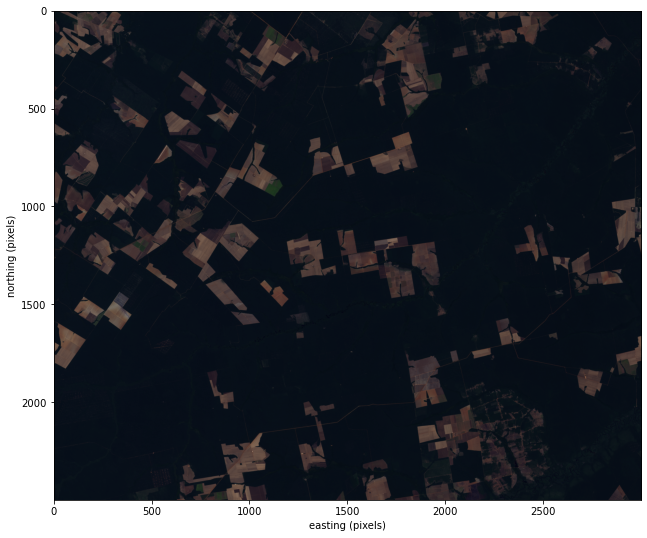

In [10]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_rgb_2014)
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

### 🧘 Your turn!

Make a color-infrared (CIR) composite of the same scene. What does it highlight and why? 

> 🧙 **Hint:** You'll need to load another band for this. Check the lecture slides and the table at the top of the notebook to find out which one.

In [11]:
brazil_2014_nir = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20140804_20200911_02_T1_cropped/LC08_L2SP_226068_20140804_20200911_02_T1_B5.TIF")
brazil_2014_nir_reflect = convert_to_reflectance(brazil_2014_nir)

In [12]:
brazil_cir_2014 = np.empty((nrows, ncols, 3), dtype="uint8")
brazil_cir_2014[:, :, 0] = skimage.exposure.rescale_intensity(brazil_2014_nir_reflect, out_range="uint8")
brazil_cir_2014[:, :, 1] = skimage.exposure.rescale_intensity(brazil_2014_red_reflect, out_range="uint8")
brazil_cir_2014[:, :, 2] = skimage.exposure.rescale_intensity(brazil_2014_green_reflect, out_range="uint8")

Text(0, 0.5, 'northing (pixels)')

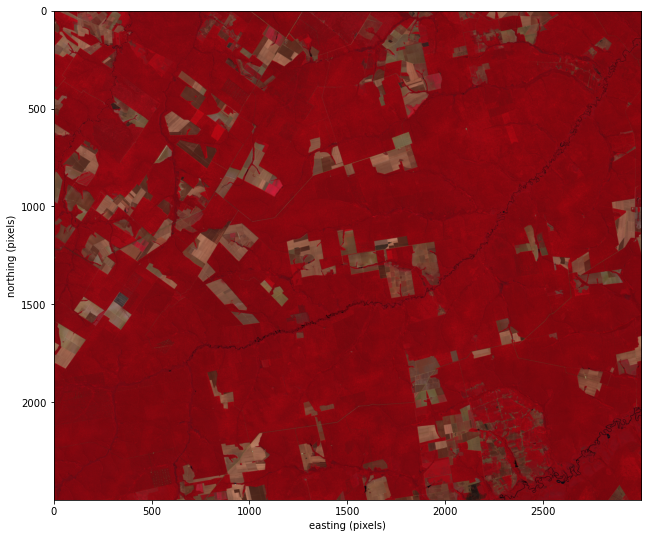

In [13]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_cir_2014)
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

---

## Indices: Normalized Difference Vegetation Index (NDVI)

Let's calculate the NDVI for the 2014 scene of Mato Grosso. Remember that the NDVI is defined as:

$$
\text{NDVI} = \dfrac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

In [14]:
def ndvi(red, nir):
    """
    Calculate the NDVI given the red and NIR bands.
    """
    result = (nir - red) / (nir + red)
    return result

In [15]:
brazil_ndvi_2014 = ndvi(brazil_2014_red_reflect, brazil_2014_nir_reflect)

Text(0, 0.5, 'northing (pixels)')

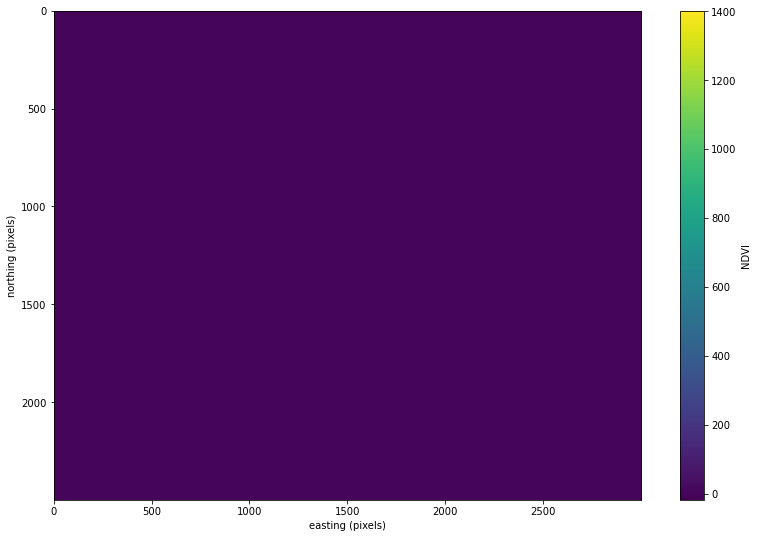

In [16]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_ndvi_2014)
plt.colorbar(label="NDVI")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

Strange that we can't see anything. This often means that there a few very large values that skew the colormap towards them. 

Since NDVI usually varies between -1 and 1, we can limit the colormap to that range when plotting. We can also use an appropriate [matplotlib colormap](https://matplotlib.org/stable/gallery/color/colormap_reference.html) for diverging data like this:

Text(0, 0.5, 'northing (pixels)')

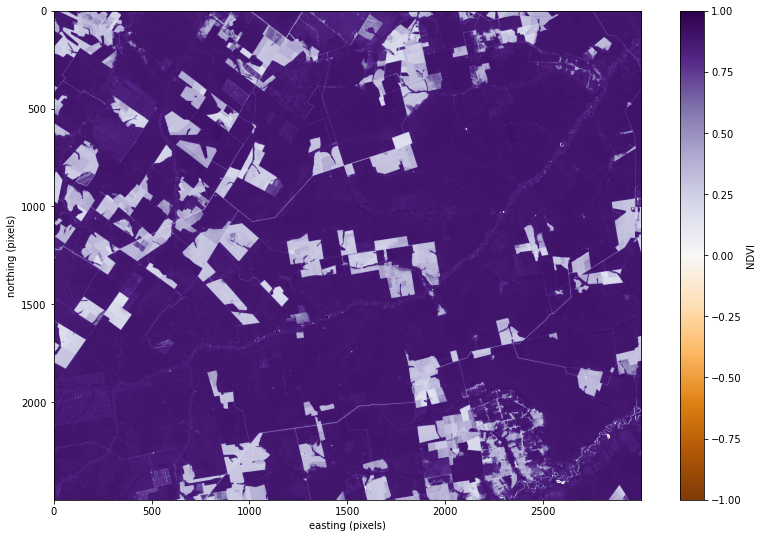

In [17]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_ndvi_2014, cmap="PuOr", vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

Notice how the densely vegetated areas have a large NDVI (close to 1) and the cleared land has close to 0 NDVI. We can also clearly make out the roads connecting the different patches of cleared land, much more so than in the composites.

### 🧘 Your turn!

Calculate the NDVI using the 2020 scene data. This was acquired at the same location (row and path numbers) and cropped to the same region. **Can you spot the differences?**

> 🧙 **Hint:** You only need the red and NIR bands for this so no need to load everything. 

> 🧙 **Hint:** Make sure you plot using the same colormap and upper and lower ranges as the image above. Not doing so makes it impossible to compare both images.

In [18]:
brazil_2020_red = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20200804_20200915_02_T1_cropped/LC08_L2SP_226068_20200804_20200915_02_T1_B4.TIF")
brazil_2020_nir = skimage.io.imread("mato_grosso/LC08_L2SP_226068_20200804_20200915_02_T1_cropped/LC08_L2SP_226068_20200804_20200915_02_T1_B5.TIF")

In [19]:
brazil_2020_red_reflect = convert_to_reflectance(brazil_2020_red)
brazil_2020_nir_reflect = convert_to_reflectance(brazil_2020_nir)

In [20]:
brazil_ndvi_2020 = ndvi(brazil_2020_red_reflect, brazil_2020_nir_reflect)

Text(0, 0.5, 'northing (pixels)')

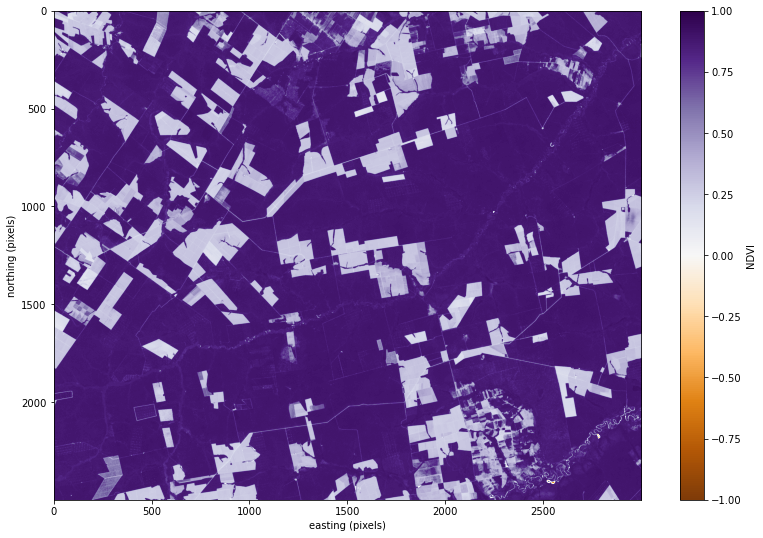

In [21]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_ndvi_2020, cmap="PuOr", vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

---

## Indices: Normalized Burn Ratio (NBR)


There are **many other indices besides the NDVI** that are designed to highlight different features. One example is the NBR, which can be used to identify burned areas, particularly when pre- and post-fire scenes are available:

$$
\text{NBR} = \dfrac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}
$$


To illustrate this, let's load the NIR and SWIR bands and calculate the NBR for the **2017 Thomas fire** in the city of Ventura, USA. We have scenes from before and after the fire.

In [22]:
ventura_nir_before = convert_to_reflectance(skimage.io.imread("thomas_fire/LC08_L2SP_042036_20171123_20200902_02_T1_cropped/LC08_L2SP_042036_20171123_20200902_02_T1_B5.TIF"))
ventura_swir_before = convert_to_reflectance(skimage.io.imread("thomas_fire/LC08_L2SP_042036_20171123_20200902_02_T1_cropped/LC08_L2SP_042036_20171123_20200902_02_T1_B6.TIF"))
ventura_nir_after = convert_to_reflectance(skimage.io.imread("thomas_fire/LC08_L2SP_042036_20180126_20200902_02_T1_cropped/LC08_L2SP_042036_20180126_20200902_02_T1_B5.TIF"))
ventura_swir_after = convert_to_reflectance(skimage.io.imread("thomas_fire/LC08_L2SP_042036_20180126_20200902_02_T1_cropped/LC08_L2SP_042036_20180126_20200902_02_T1_B6.TIF"))

Now we can calculate the NBR (making a function since we do this multiple times).

In [23]:
def nbr(nir, swir):
    """
    Calculate the NBR from the NIR and SWIR bands.
    """
    result = (nir - swir) / (nir + swir)
    return result

In [24]:
ventura_nbr_before = nbr(ventura_nir_before, ventura_swir_before)
ventura_nbr_after = nbr(ventura_nir_after, ventura_swir_after)

Plot both using the same colormap and range. NBR is also usually between -1 and 1.

Text(0, 0.5, 'northing (pixels)')

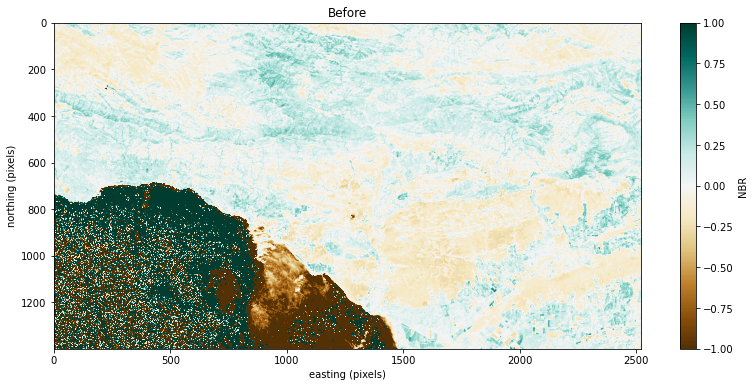

In [25]:
plt.figure(figsize=(14, 6))
plt.imshow(ventura_nbr_before, cmap="BrBG", vmin=-1, vmax=1)
plt.colorbar(label="NBR")
plt.title("Before")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

Text(0, 0.5, 'northing (pixels)')

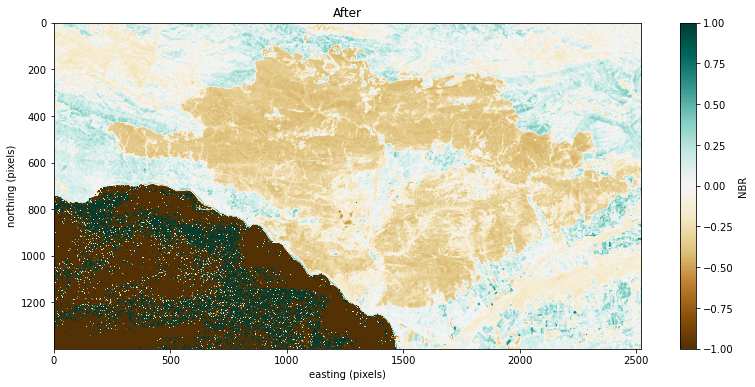

In [26]:
plt.figure(figsize=(14, 6))
plt.imshow(ventura_nbr_after, cmap="BrBG", vmin=-1, vmax=1)
plt.colorbar(label="NBR")
plt.title("After")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

### 🧘 Your turn!

Calculate and plot the difference in NBR (dNBR):

$$
\text{dNBR} = \text{NBR}_\text{before} - \text{NBR}_\text{after}
$$

What does it show? 

In [27]:
ventura_dnbr = ventura_nbr_before - ventura_nbr_after

Text(0, 0.5, 'northing (pixels)')

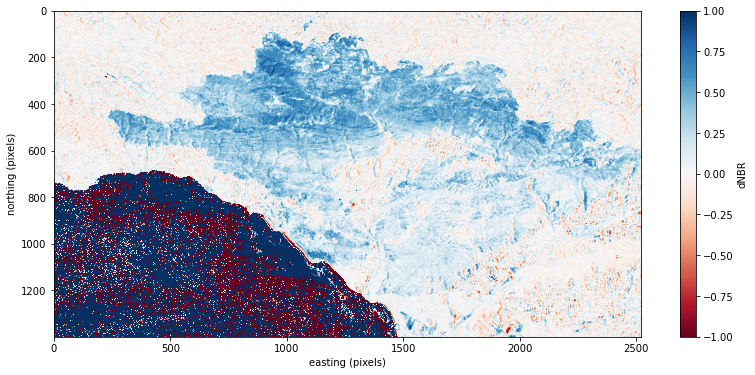

In [28]:
plt.figure(figsize=(14, 6))
plt.imshow(ventura_dnbr, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar(label="dNBR")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

### 🏆 Bonus round

Estimate the area that was moderately to severely burned (dNBR values > 0.3). Remember that for Landsat 8, each pixel of the image is 30 m X 30 m in area. **What are the sources of uncertainty in this calculation?**

How does your estimate compare with official estimates (Google "Thomas fire California 2017")? 

In [29]:
pixels_burned = np.sum(ventura_dnbr > 0.3)
area_burned_km2 = pixels_burned * 30 ** 2 * 1e-6
area_burned_ac = area_burned_km2 * 247.10538161
print("Area burned:", area_burned_km2, "km² /", area_burned_ac, "acres")

Area burned: 1020.0915 km² / 252070.09938461732 acres


---

## Extra: Contrast stretching composites

The RBG of Mato Grosso looks a bit dark, doesn't it? We need to do some **contrast stretching**. But we can't just stretch the entire composite since some bands may have different different histograms, which could make the colors look off. So we have to **rescale each band independently**. 

To get a sense for the bounds we should use for the stretching, let's make histograms of each band:

Text(0.5, 0, 'reflectance')

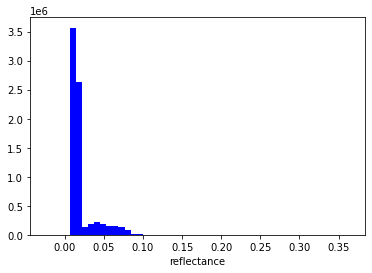

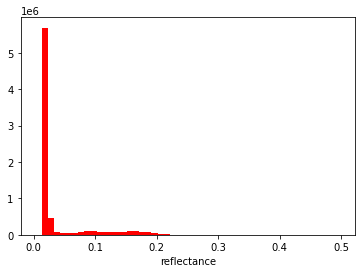

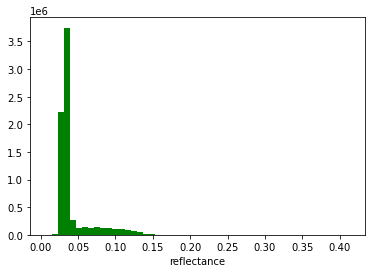

In [30]:
nbins = 50
plt.figure()
plt.hist(brazil_2014_blue_reflect.ravel(), color="blue", bins=nbins)
plt.xlabel("reflectance")
plt.figure()
plt.hist(brazil_2014_red_reflect.ravel(), color="red", bins=nbins)
plt.xlabel("reflectance")
plt.figure()
plt.hist(brazil_2014_green_reflect.ravel(), color="green", bins=nbins)
plt.xlabel("reflectance")

These have most of their values in the range of 0 to 0.1 reflectance so let's use that. We'll apply these bounds to each of our bands separately when making the RBG composite.

In [31]:
lower, upper = 0.0, 0.1
brazil_rgb_2014_rescaled = np.empty((nrows, ncols, 3), dtype="uint8")
brazil_rgb_2014_rescaled[:, :, 0] = skimage.exposure.rescale_intensity(brazil_2014_red_reflect, in_range=(lower, upper), out_range="uint8")
brazil_rgb_2014_rescaled[:, :, 1] = skimage.exposure.rescale_intensity(brazil_2014_green_reflect, in_range=(lower, upper), out_range="uint8")
brazil_rgb_2014_rescaled[:, :, 2] = skimage.exposure.rescale_intensity(brazil_2014_blue_reflect, in_range=(lower, upper), out_range="uint8")

Text(0, 0.5, 'northing (pixels)')

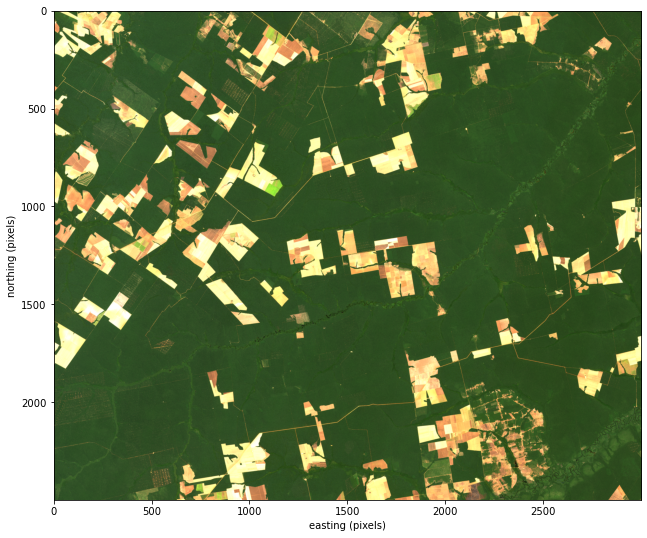

In [32]:
plt.figure(figsize=(14, 9))
plt.imshow(brazil_rgb_2014_rescaled)
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

> 🚨 **IMPORTANT** 🚨 <br/>
> These decisions about contrast stretching bounds are **subjective** by nature and are mostly meant to **aid visualization**. You need to keep in mind that the color you see in the image above is **not necessarily what you would see with your eyes** (that's why the term "true color" is currently being discouraged). **Do not use contrast stretching when calculating indices**.

----

## Extra: Issues when tracking changes with time

When tracking changes with time, it can be useful to calculate the difference between a pre-event and a post-event index (like dNBR). An **assumption** we make when doing so is that **each corresponding pixel in the two scenes is at exactly the same place**. 

**This is not necessarily the case** and usually requires further corrections to be applied to align both scenes before we can do any calculations on them. When the two scenes are close in time, the differences are small (like in our dNBR example). But the misaligned tends to increase with time.

Let's take a look at the difference between the NDVI from the 2014 and 2020 from Mato Grosso, Brazil, as an example:

In [33]:
ndvi_difference = brazil_ndvi_2014 - brazil_ndvi_2020

Text(0, 0.5, 'northing (pixels)')

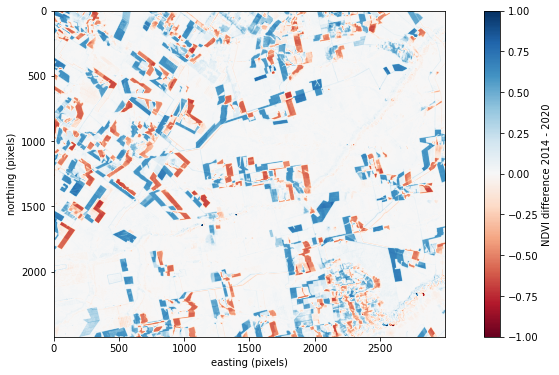

In [34]:
plt.figure(figsize=(14, 6))
plt.imshow(ndvi_difference, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar(label="NDVI difference 2014 - 2020")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")

The blue patches in that image are conspicuously all on the Western side while the red patches are on the Eastern side. This should be **ringing some alarm bells** in your head. The reason we see these differences is because of slight drifts in the satellite's orbit that accumulate over time (in this case, 6 years). ]

Look closely at the dNBR figure above and you'll see this same pattern (particularly around the coast). They will be smaller since the time difference is only about 1 month but they will still be there.

The corrections that need to applied are beyond what we can do in this module and they require working with the actual geographic coordinates of each pixel (see [Image registration](https://en.wikipedia.org/wiki/Image_registration) and search for "satellite image co-registration"). For our purposes, **it's important to keep this effect in mind when doing your calculations and avoid interpreting these patches as actual features of the data**.